In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import PIL
import PIL.Image
from PIL import Image
import os
import tensorflow as tf

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim

In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [4]:
test_loc = 'BoneFractureYolo8/test/images'
train_loc = 'BoneFractureYolo8/train/images'
val_loc = 'BoneFractureYolo8/valid/images'

In [5]:
def display_images(image_dir, num_images=10):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    if len(image_files) < num_images:
                num_images = len(image_files) 
                print(f"Warning: Only {num_images} images available in {image_dir}")

    selected_images = random.sample(image_files, num_images)

    cols = 5 
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3)) 
    
    for i, image_file in enumerate(selected_images): 
          img_path = os.path.join(image_dir, image_file) 
          img = Image.open(img_path) 
          plt.subplot(rows, cols, i + 1) 
          plt.imshow(img) 
          plt.axis('off')

    plt.show()

Displaying Test images:


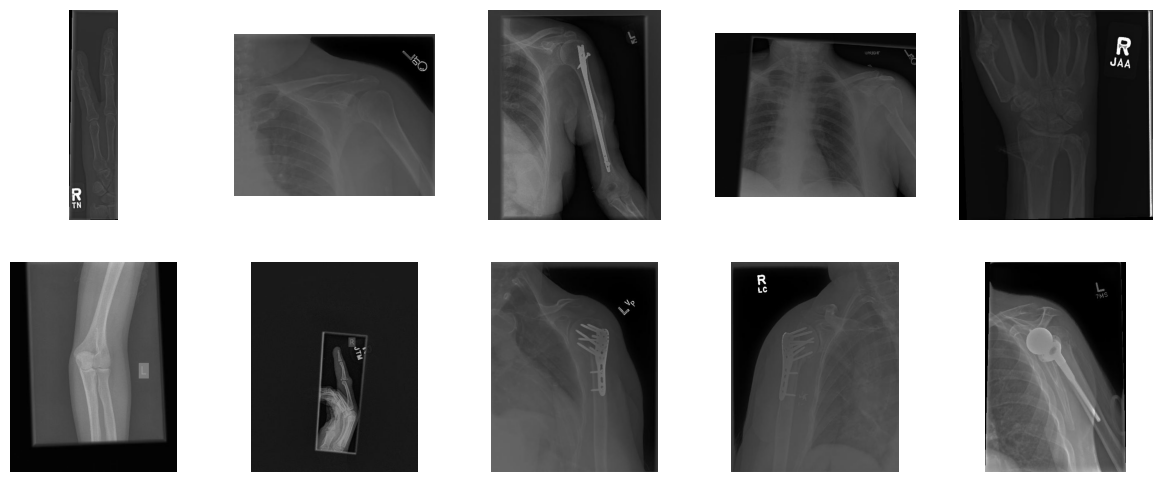

In [6]:
print("Displaying Test images:")
display_images(test_loc)

Displaying Train images:


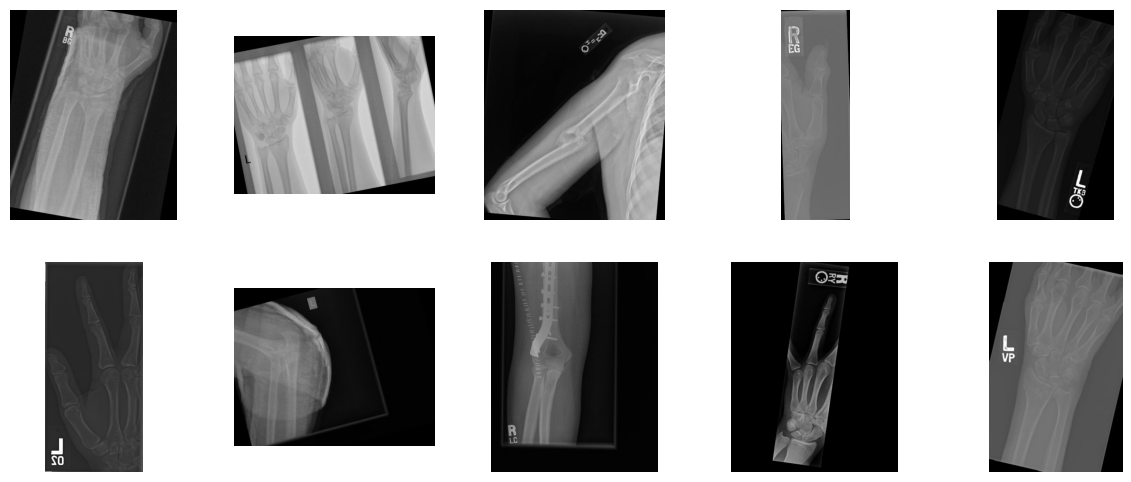

In [7]:
print("Displaying Train images:")
display_images(train_loc)

Displaying Validation images:


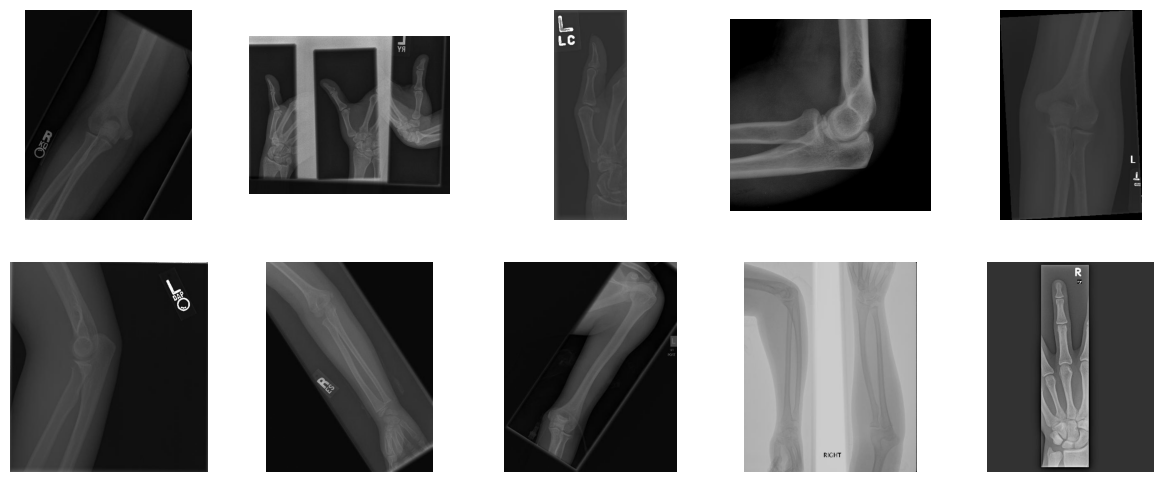

In [8]:
print("Displaying Validation images:")
display_images(val_loc)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None): 
        self.image_dir = image_dir 
        self.transform = transform 
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self): 
        return len(self.image_files)
    def __getitem__(self, idx): 
        img_name = os.path.join(self.image_dir, self.image_files[idx]) 
        image = Image.open(img_name).convert('RGB')

        if self.transform: image = self.transform(image) 
        return image

In [11]:
transform = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor()])

In [12]:
train_dataset = CustomImageDataset(train_loc, transform=transform)
val_dataset = CustomImageDataset(val_loc, transform=transform)
test_dataset = CustomImageDataset(test_loc, transform=transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)

C:\Users\User\anaconda3\envs\keras_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\keras_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images in train_loader:
        images = images.to(device)
        labels = torch.ones(images.size(0)).to(device)

        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.0216
Epoch 2/10, Loss: 0.0002
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [18]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
with torch.no_grad():
    val_loss = 0.0
    for images in val_loader:
        images = images.to(device)
        labels = torch.ones(images.size(0)).to(device)

        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

In [20]:
print(f'Validation Loss: {avg_val_loss:.4f}')

Validation Loss: 0.0000
